In [1]:
import anndata.logging
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn


In [3]:
import mubind as mb

In [4]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [5]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
pwms = mb.datasets.archetypes()
# pwms = mb.datasets.genre()

HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme
table_s3-1.meme
table_s3-2.meme
table_s3-3.meme
table_s3-4.meme
table_s3-5.meme
table_s3-6.meme
# motifs loaded 2179


In [7]:
clu = mb.datasets.archetypes_clu()
anno = mb.datasets.archetypes_anno()

In [8]:
reduced_groups = [p.to_numpy() for p in pwms]
# print(len(reduced_groups))

In [9]:
len(reduced_groups)

286

In [10]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [11]:
for pi, p in enumerate(reduced_groups):
    print(pi, p.shape)

0 (4, 9)
1 (4, 18)
2 (4, 9)
3 (4, 13)
4 (4, 14)
5 (4, 13)
6 (4, 17)
7 (4, 17)
8 (4, 13)
9 (4, 12)
10 (4, 15)
11 (4, 8)
12 (4, 11)
13 (4, 14)
14 (4, 12)
15 (4, 12)
16 (4, 17)
17 (4, 10)
18 (4, 18)
19 (4, 17)
20 (4, 11)
21 (4, 12)
22 (4, 17)
23 (4, 11)
24 (4, 12)
25 (4, 14)
26 (4, 14)
27 (4, 10)
28 (4, 15)
29 (4, 10)
30 (4, 10)
31 (4, 14)
32 (4, 9)
33 (4, 14)
34 (4, 10)
35 (4, 14)
36 (4, 12)
37 (4, 15)
38 (4, 16)
39 (4, 18)
40 (4, 12)
41 (4, 9)
42 (4, 14)
43 (4, 17)
44 (4, 18)
45 (4, 13)
46 (4, 18)
47 (4, 12)
48 (4, 12)
49 (4, 14)
50 (4, 18)
51 (4, 19)
52 (4, 10)
53 (4, 10)
54 (4, 12)
55 (4, 16)
56 (4, 14)
57 (4, 8)
58 (4, 15)
59 (4, 17)
60 (4, 17)
61 (4, 12)
62 (4, 15)
63 (4, 14)
64 (4, 10)
65 (4, 8)
66 (4, 12)
67 (4, 10)
68 (4, 10)
69 (4, 12)
70 (4, 6)
71 (4, 15)
72 (4, 10)
73 (4, 13)
74 (4, 9)
75 (4, 10)
76 (4, 12)
77 (4, 9)
78 (4, 10)
79 (4, 21)
80 (4, 12)
81 (4, 17)
82 (4, 10)
83 (4, 14)
84 (4, 12)
85 (4, 13)
86 (4, 20)
87 (4, 9)
88 (4, 9)
89 (4, 8)
90 (4, 12)
91 (4, 20)
92 (4, 19)


In [12]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(2 + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

In [13]:
# unfreeze(model, None)
# model.binding_modes.update_grad_mono(0, True)
# model.binding_modes.update_grad_di(0, True)

In [14]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0
Using device: cuda:0


In [15]:
# atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
os.path.exists(atac_path)

True

In [16]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [17]:
!ls -ltrh ../../../annotations/scatac/

total 2.9G
-rwxrwxrwx 1 rio rio 2.3G Jan 23 23:02 pancreas_multiome_2022_processed.h5ad
-rwxrwxrwx 1 rio rio 381K Jan 24 19:01 pancreas_multiome_2022_processed_sample_100.h5ad
-rwxrwxrwx 1 rio rio 2.4M Jan 24 19:01 pancreas_multiome_2022_processed_sample_1000.h5ad
-rwxrwxrwx 1 rio rio 1.2M Jan 24 19:01 pancreas_multiome_2022_processed_sample_500.h5ad
-rwxrwxrwx 1 rio rio  50M Jan 25 10:54 pancreas_multiome_2022_processed_sample_10000.h5ad
-rwxrwxrwx 1 rio rio 122M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p20000.h5ad
-rwxrwxrwx 1 rio rio 170M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p30000.h5ad
-rwxrwxrwx 1 rio rio 325M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad


In [118]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [119]:
adata.shape

(16918, 242922)

In [120]:
import gc
gc.collect()

2186

In [121]:
rna = adata[:,adata.var.modality == 'GEX'].copy()
atac = adata[:,adata.var.modality == 'ATAC'].copy()


In [122]:
# del adata
gc.collect()

1158

In [123]:
# rna = adata[:,adata.var.modality == 'GEX'].copy()

n_sample_cells = 350
n_sample_peaks = n_sample_cells * 2


In [124]:
print(n_sample_cells, n_sample_peaks)

350 700


(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

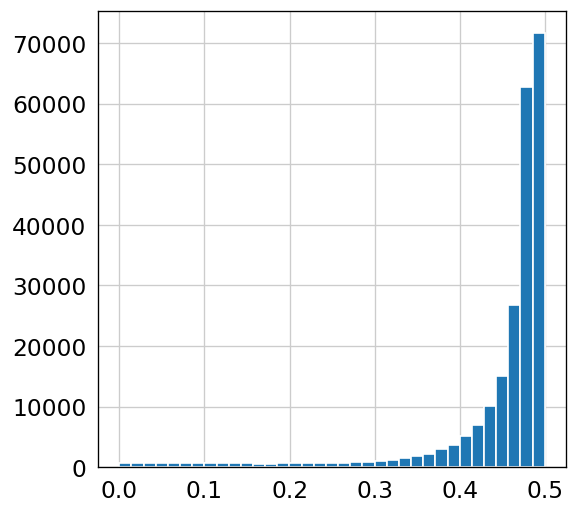

In [125]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)

In [126]:
obs_sample = pd.Index(np.random.choice(atac.obs_names, n_sample_cells))
var_sample = pd.Index(np.random.choice(atac.var_names, n_sample_peaks))
# var_sample = adata.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample), atac.var_names.isin(var_sample)]
ad.shape

(345, 700)

In [127]:
# contributions per newly added kernel
from matplotlib import rcParams
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80

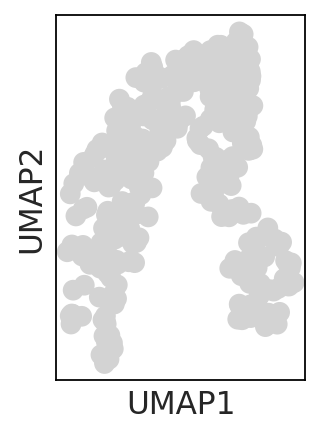

In [128]:

sc.pl.umap(ad)

In [129]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [130]:
extend = ((ad.var['end'] - ad.var['start']).min() / 2).astype(int)
extend

165

In [131]:
ad.var['chr'].value_counts()

chr1     62
chr4     47
chr2     47
chr11    46
chr8     44
chr5     39
chr6     37
chr10    37
chr14    36
chr3     35
chr17    35
chr12    34
chr13    34
chr7     32
chr9     30
chr18    28
chr15    21
chr16    21
chrX     20
chr19    15
Name: chr, dtype: int64

In [132]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [133]:
ad.var['summit.end'] - ad.var['summit.start']

1-5072970-5073833        330
1-14184005-14184916      330
1-15644362-15645252      330
1-15878917-15879746      330
1-19211778-19212532      330
                        ... 
X-134331230-134332109    330
X-139240849-139241721    330
X-151047560-151048020    330
X-157489736-157490517    330
X-164436338-164437065    330
Length: 700, dtype: int64

In [134]:
ad.shape

(345, 700)

In [135]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmplx6g6j7p
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmplx6g6j7p -fo /tmp/tmpqdkrt300
get fasta
/tmp/tmpqdkrt300


In [136]:
len(seqs)

700

In [137]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [138]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

# general binarization
# next_data[next_data != 0] = 1

In [139]:

next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel
print(next_data_sel.shape)
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0

print(df.shape)
df = df[~zero_counts] # remove zeroes

df.shape

(700, 346)
(700, 345)


(688, 345)

In [140]:
zero_counts

seq
GTCCCCGAGAGGCCGGGGGGAGGGGAGGGCGGCGGGGGTGGAGGATCTTACTCACACGCGAGCCCCGGGACGCACAATCCACAGACGACGGGTCCCCCACCCCCCACCCCGTCCAGGGAAGCCGGGACACAACGGGTCAGCAAGGCCCTCTCCCTCCCCGAACTGGCAACCCCGGGGGGTGACTCGCGTCGGCACACGAAAGCCGCGGCGTCCCGCGGGCCGGCGCCTGAGCGGGTACCGCCCGGGCGAGGACACAGAGATGAAGAAAAGCCAAGGCGGCCACGGGCCCCGACCGCCCCTAGCGGCCGCGTGCGGCGCAAAGACGCCCAC    False
AGGCGTCCGGGCCCGCGGTCGGCAGCGCGCACGGGCCAACCAAGCCGCGCCTCCGCGAGAAGCGCCTCCGCGTGACTGACGGGGGACTCTGCGGACCAACGGGCTGGGCGGCCCGGCGGCGCGCGCTCCCGCCGGCCAATCAGAGCGCCGGGCGGGGAAAGTGGGCGGAGCGAGGCCAGGGTAGGGTGAGCGGCCTCCGAAGCGGAGCGGGGCTCGGAGGAGACACTTTTTTTTTTTCCTCCCTCCTTCCCTCCTCTCCTCCTCCCTTCCCTTCCCCTCTCCTCCCCTCTCTCCTCCTTCCCCCCTCGGTCCGCTGGAGCCTGCTGGGGC    False
TCCTGGAGGCGTTCCTATTGGCTGTGACTTTTCTCGCTCCCGCTCCTAATTAGCGAGCGCTACCGCTCCTCACAATTCCGTCCAATCATAATCCGAGGTGGGTTGGGCTAATTGCGAGAATTTCCACATGCGTAACAGAGGCTAGTTAGTAATTGGTTCAGCTTCATGCCACTTAGTGACTGACGGATGGTTATTGGTCAATGTACCAGACGGAAAGCTGGGTGGAATTTTCGCCTTTGTATCGCGCACAGCTTCTCATCCGGGTATCCGGCGGATCTGACTGACGGCCGCATCGTCCTATCAGTGCTTCTGAGAG

In [141]:
df.shape

(688, 345)

In [142]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(237360, 3)
345
0      688
137    688
127    688
128    688
129    688
      ... 
69     688
70     688
71     688
72     688
199    688
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
GTCCCCGAGAGGCCGGGGGGAGGGGAGGGCGGCGGGGGTGGAGGATCTTACTCACACGCGAGCCCCGGGACGCACAATCCACAGACGACGGGTCCCCCACCCCCCACCCCGTCCAGGGAAGCCGGGACACAACGGGTCAGCAAGGCCCTCTCCCTCCCCGAACTGGCAACCCCGGGGGGTGACTCGCGTCGGCACACGAAAGCCGCGGCGTCCCGCGGGCCGGCGCCTGAGCGGGTACCGCCCGGGCGAGGACACAGAGATGAAGAAAAGCCAAGGCGGCCACGGGCCCCGACCGCCCCTAGCGGCCGCGTGCGGCGCAAAGACGCCCAC,1.0,1.0,0
AGGCGTCCGGGCCCGCGGTCGGCAGCGCGCACGGGCCAACCAAGCCGCGCCTCCGCGAGAAGCGCCTCCGCGTGACTGACGGGGGACTCTGCGGACCAACGGGCTGGGCGGCCCGGCGGCGCGCGCTCCCGCCGGCCAATCAGAGCGCCGGGCGGGGAAAGTGGGCGGAGCGAGGCCAGGGTAGGGTGAGCGGCCTCCGAAGCGGAGCGGGGCTCGGAGGAGACACTTTTTTTTTTTCCTCCCTCCTTCCCTCCTCTCCTCCTCCCTTCCCTTCCCCTCTCCTCCCCTCTCTCCTCCTTCCCCCCTCGGTCCGCTGGAGCCTGCTGGGGC,1.0,2.0,0
TCCTGGAGGCGTTCCTATTGGCTGTGACTTTTCTCGCTCCCGCTCCTAATTAGCGAGCGCTACCGCTCCTCACAATTCCGTCCAATCATAATCCGAGGTGGGTTGGGCTAATTGCGAGAATTTCCACATGCGTAACAGAGGCTAGTTAGTAATTGGTTCAGCTTCATGCCACTTAGTGACTGACGGATGGTTATTGGTCAATGTACCAGACGGAAAGCTGGGTGGAATTTTCGCCTTTGTATCGCGCACAGCTTCTCATCCGGGTATCCGGCGGATCTGACTGACGGCCGCATCGTCCTATCAGTGCTTCTGAGAGCTCCCAGGTCCGGC,1.0,1.0,0
CGCGGGGGGAGGGGCAGGGAGAGCTGAAGGGCGGGGGAGCGCCCCGGATGCCCCGCCTCCGGAGGCGGAGCCTTCTCTCATTGGGCTTTGCGCCTCCCGCCGCCGCCACTGGCCCCGCCCCTAGAACGCAGCCCGTCCCCTCTGGCCTCTGCTGTGGGGTGCCTGAGAGCCAGCCCGGGAGCCTTATGGGCTACTCGCGCCGGCACTCCACAGATGGTCGGTCAGTCCAGCCAGCAAAGTGTTGTCCCCGGATCCTGCTCCTTCCCTATTATTAGCAGTTGGGGACTTAGAGGTGTTATATAGGACCGAATAAAGTGTACCCGTAGCCGA,1.0,0.0,0
CCTGTCAGCGGCGCGGCGCCATGGACGCCCACCCGGAGTTTCAGCGCTGCCGCGGGACCCCCATCCCACTACCCTCCGCCCTCTTCCGCCGCCGCCGCCGCCTCCGCCTCCTCCTCCTCCGCGGAGACCCCCGCCCACTCCACACACTCTCCCATCATGCAGCGGGGAACCGCTGCTGTCCATACGTCACTTCCGGGCGCAGGTGGCTAGGTCGGGGCCGGGCGCTGGTGGGTGCCGGGGTGGGGGAGGACACTCCAGGGGAATTAGTGTCACAGACTTCTTACTTCTGCGCAGGCGCCGTCGTGTGGAACGACGTTCGCCATTTTGGTT,1.0,1.0,0


### This is the relatedness graph and used for dynamics filters learning

In [143]:
ad = ad[:,~zero_counts].copy()

In [144]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [145]:
n_batch = len(set(dataset.batch))
n_batch

1

In [146]:
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [147]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [148]:
n_kernels = len(reduced_groups)
# n_kernels = 8

In [149]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()
# criterion = torch.nn.CrossEntropyLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=True,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       # optimize_prob_act=True,
                                       # p_dropout=.8,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None,
                                       prepare_knn=True,
                                       p_dropout=0.8,
                                       adata=ad) # .cuda()



If indicating priors, then the model will initialize them from the previous binding modes generated during preparation

In [150]:

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU


In [151]:
model = model.to(device)


In [152]:
print(model.selex_module.log_dynamic)
print(model.selex_module.log_etas)

Parameter containing:
tensor([0.68, 0.68, 0.02, 0.86, 0.16, 0.66, 0.55, 0.28, 0.49, 0.60, 0.50, 0.45,
        0.74, 0.39, 0.37, 0.52, 0.84, 0.37, 0.99, 0.62, 0.41, 0.82, 0.92, 0.67,
        0.24, 0.53, 0.19, 0.90, 0.57, 0.36, 0.13, 0.21, 0.61, 0.04, 0.53, 0.64,
        0.60, 0.24, 0.28, 0.25, 0.92, 0.94, 0.02, 0.28, 0.88, 0.60, 0.85, 0.87,
        0.05, 0.31, 0.11, 0.47, 0.76, 0.56, 0.34, 0.24, 0.54, 0.42, 0.11, 0.07,
        0.64, 0.60, 0.82, 0.44, 0.24, 0.58, 0.01, 0.55, 0.67, 0.92, 0.80, 0.88,
        0.04, 0.74, 0.34, 0.89, 0.39, 0.65, 0.40, 0.55, 0.63, 0.04, 0.74, 0.26,
        0.52, 0.51, 0.61, 0.55, 0.36, 0.57, 0.78, 0.87, 0.09, 0.40, 0.23, 0.61,
        0.94, 0.89, 0.47, 1.00, 0.14, 0.80, 0.31, 0.86, 0.04, 0.81, 0.78, 0.07,
        0.34, 0.41, 0.94, 0.98, 0.45, 0.09, 0.26, 0.24, 0.08, 0.13, 0.05, 0.81,
        0.93, 0.26, 0.44, 0.83, 0.03, 0.25, 0.15, 0.78, 0.04, 0.31, 0.56, 0.92,
        0.95, 0.14, 0.59, 0.74, 0.87, 0.04, 0.55, 0.55, 0.77, 0.79, 0.85, 0.38,
        0.12, 0.54

In [153]:
from IPython.core import ultratb; ultratb.VerboseTB._tb_highlight = "bg:ansired"

In [154]:
# model.prepare_knn(ad)
# if 'cuda' in str(device):
#     model.selex_module = model.selex_module.cuda()

True
12
0 out of 288...


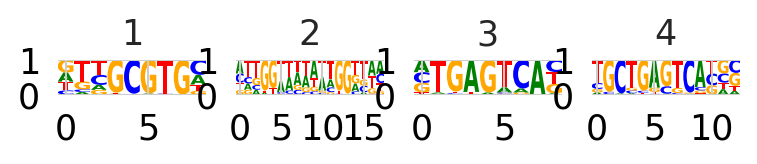

In [155]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=10, n_cols=12, stop_at=5) # n_cols=len(reduced_groups))

In [156]:
# model.binding_modes.prob_act

In [157]:
mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})
# mb.pl.conv(model, n_cols=2)


In [158]:
model.loss_history

[]

In [159]:
conn = model.selex_module.conn_sparse

In [160]:
self = model

conn = self.selex_module.conn_sparse
log_dynamic = self.selex_module.log_dynamic
idx = conn.indices()

# prepare combinations based on common indexes
uniq_idx = idx.unique()
all_combinations = []
for u_idx in uniq_idx:
    pos = torch.arange(idx.size(1))
    sub_pos = pos[(idx[:, :][0] == u_idx) | (idx[:, :][1] == u_idx)]
    c = torch.combinations(sub_pos, r=2)
    all_combinations.append(c)

all_pos = torch.cat(all_combinations)
pairs = idx[:, all_pos].reshape(all_pos.shape[0], 4)
# pairs = idx[all_pos].reshape(all_pos.shape[0], 4)
mask1 = (pairs[:, 0] == pairs[:, 2]) | (pairs[:, 1] == pairs[:, 3])
mask2 = (pairs[:, 0] != pairs[:, 1]) & (pairs[:, 2] != pairs[:, 3])

all_pos = all_pos[mask1 & mask2]
pairs = pairs[mask1 & mask2]

a = log_dynamic[all_pos[:, 0]]
b = log_dynamic[all_pos[:, 1]]

print(a)
print(b)


tensor([0.68, 0.68, 0.16, 0.66, 0.68, 0.60, 0.50, 0.16, 0.16, 0.45, 0.45, 0.74,
        0.52, 0.84, 0.37, 0.37, 0.28, 0.50, 0.82, 0.07, 0.67, 0.67, 0.67, 0.19,
        0.02, 0.04, 0.53, 0.64, 0.64, 0.60, 0.24, 0.37, 0.92, 0.92, 0.60, 0.60,
        0.49, 0.25, 0.39, 0.39, 0.39, 0.11, 0.11, 0.61, 0.24, 0.54, 0.42, 0.11,
        0.24, 0.58, 0.01, 0.55, 0.42, 0.42, 0.92, 0.57, 0.88, 0.04, 0.88, 0.68,
        0.68, 0.68, 0.04, 0.04, 0.04, 0.54, 0.54, 0.24, 0.34, 0.55, 0.19, 0.11,
        0.60, 0.87, 0.09, 0.64, 0.92, 0.47, 1.00, 0.14, 0.80, 0.31, 0.86, 0.86,
        0.86, 0.04, 0.04, 0.04, 0.74, 0.52, 0.52, 0.07, 0.07, 0.45, 0.04, 0.08,
        0.08, 0.13, 0.05, 0.05, 0.04, 0.04, 0.09, 0.61, 0.78, 0.78, 0.78, 0.08,
        0.08, 0.78, 0.94, 0.56, 0.59, 0.04, 0.04, 0.55, 0.55, 0.55, 0.14, 0.14,
        0.77, 0.79, 0.38, 0.38, 0.13, 0.13, 0.31, 0.31, 0.12, 0.54, 0.52, 0.04,
        0.31, 0.11, 0.79, 0.79, 0.76, 0.04, 0.03, 0.38, 0.38, 0.19, 1.00, 0.38,
        0.38, 0.38, 0.64, 0.20, 0.80, 0.

In [161]:
print(all_pos.shape)


torch.Size([170, 2])


In [162]:
conn

tensor(indices=tensor([[  3,   6,   6,   8,   9,  14,  15,  16,  17,  25,  27,
                         29,  29,  29,  30,  31,  33,  38,  38,  41,  44,  48,
                         48,  49,  51,  52,  52,  53,  56,  58,  62,  72,  75,
                         75,  78,  78,  79,  81,  87,  89,  89,  91,  93,  94,
                         98, 100, 100, 101, 102, 102, 105, 105, 106, 107, 110,
                        112, 112, 114, 115, 117, 120, 121, 122, 129, 136, 138,
                        140, 141, 144, 146, 146, 149, 149, 152, 161, 161, 161,
                        163, 164, 168, 168, 170, 171, 174, 177, 180, 181, 184,
                        186, 187, 189, 192, 193, 194, 194, 196, 197, 199, 200,
                        201, 203, 205, 206, 210, 210, 212, 213, 219, 219, 219,
                        220, 221, 222, 226, 227, 232, 234, 234, 234, 235, 240,
                        242, 244, 245, 246, 247, 251, 252, 252, 252, 256, 256,
                        258, 259, 260, 261, 264, 266

In [163]:
# edges = conn[all_pos]
print(a.shape, conn.shape, pairs.shape)
all_pos[-1]

torch.Size([170]) torch.Size([345, 345]) torch.Size([170, 4])


tensor([179, 180])

In [164]:
model, best_loss = model.optimize_iterative(train, n_epochs=[25] + [10] * (n_kernels + 1),
                                            show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                            opt_one_step=True,
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            skip_kernels=range(1, 500),
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=250, log_each=1, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
activities status False
s

In [165]:
print(model.selex_module.log_dynamic)
# print(model.selex_module.log_etas)

Parameter containing:
tensor([ 4.19e-01,  4.02e-01,  3.24e-01,  5.20e-01,  5.05e-01,  6.11e-01,
         6.05e-01,  4.59e-01,  5.95e-01,  7.15e-01,  5.57e-01,  5.07e-01,
         5.71e-01,  4.54e-01, -1.28e-01,  4.66e-01,  6.08e-01,  4.84e-01,
         1.15e+00,  5.62e-01,  4.60e-01,  4.65e-01,  8.45e-01,  4.90e-01,
         2.37e-01,  4.83e-01,  5.14e-01,  5.55e-01,  6.31e-01,  6.27e-01,
         2.96e-01,  3.15e-01,  3.50e-01,  3.96e-01,  4.98e-01,  5.01e-01,
         7.65e-01,  4.19e-01,  4.86e-01,  1.47e-01,  6.02e-01,  7.72e-01,
         4.18e-04,  5.11e-01,  8.09e-01,  7.08e-01,  7.14e-01,  6.00e-01,
         1.50e-01,  5.90e-01,  4.21e-01,  4.18e-01,  4.21e-01,  2.74e-01,
         4.27e-01,  3.91e-01,  3.91e-01,  5.73e-01,  3.44e-01,  4.35e-01,
         1.14e+00,  5.84e-01,  1.36e+00, -9.30e-02,  2.38e-01,  4.75e-01,
         1.13e-01,  5.80e-01,  4.76e-01,  5.85e-01,  5.55e-01,  4.92e-01,
         4.30e-01,  8.12e-01,  3.93e-01,  4.80e-01,  3.87e-01,  4.46e-01,
         6.33e-0

In [166]:
atac.shape

(16918, 228259)

Text(0, 0.5, 'similar weights loss')

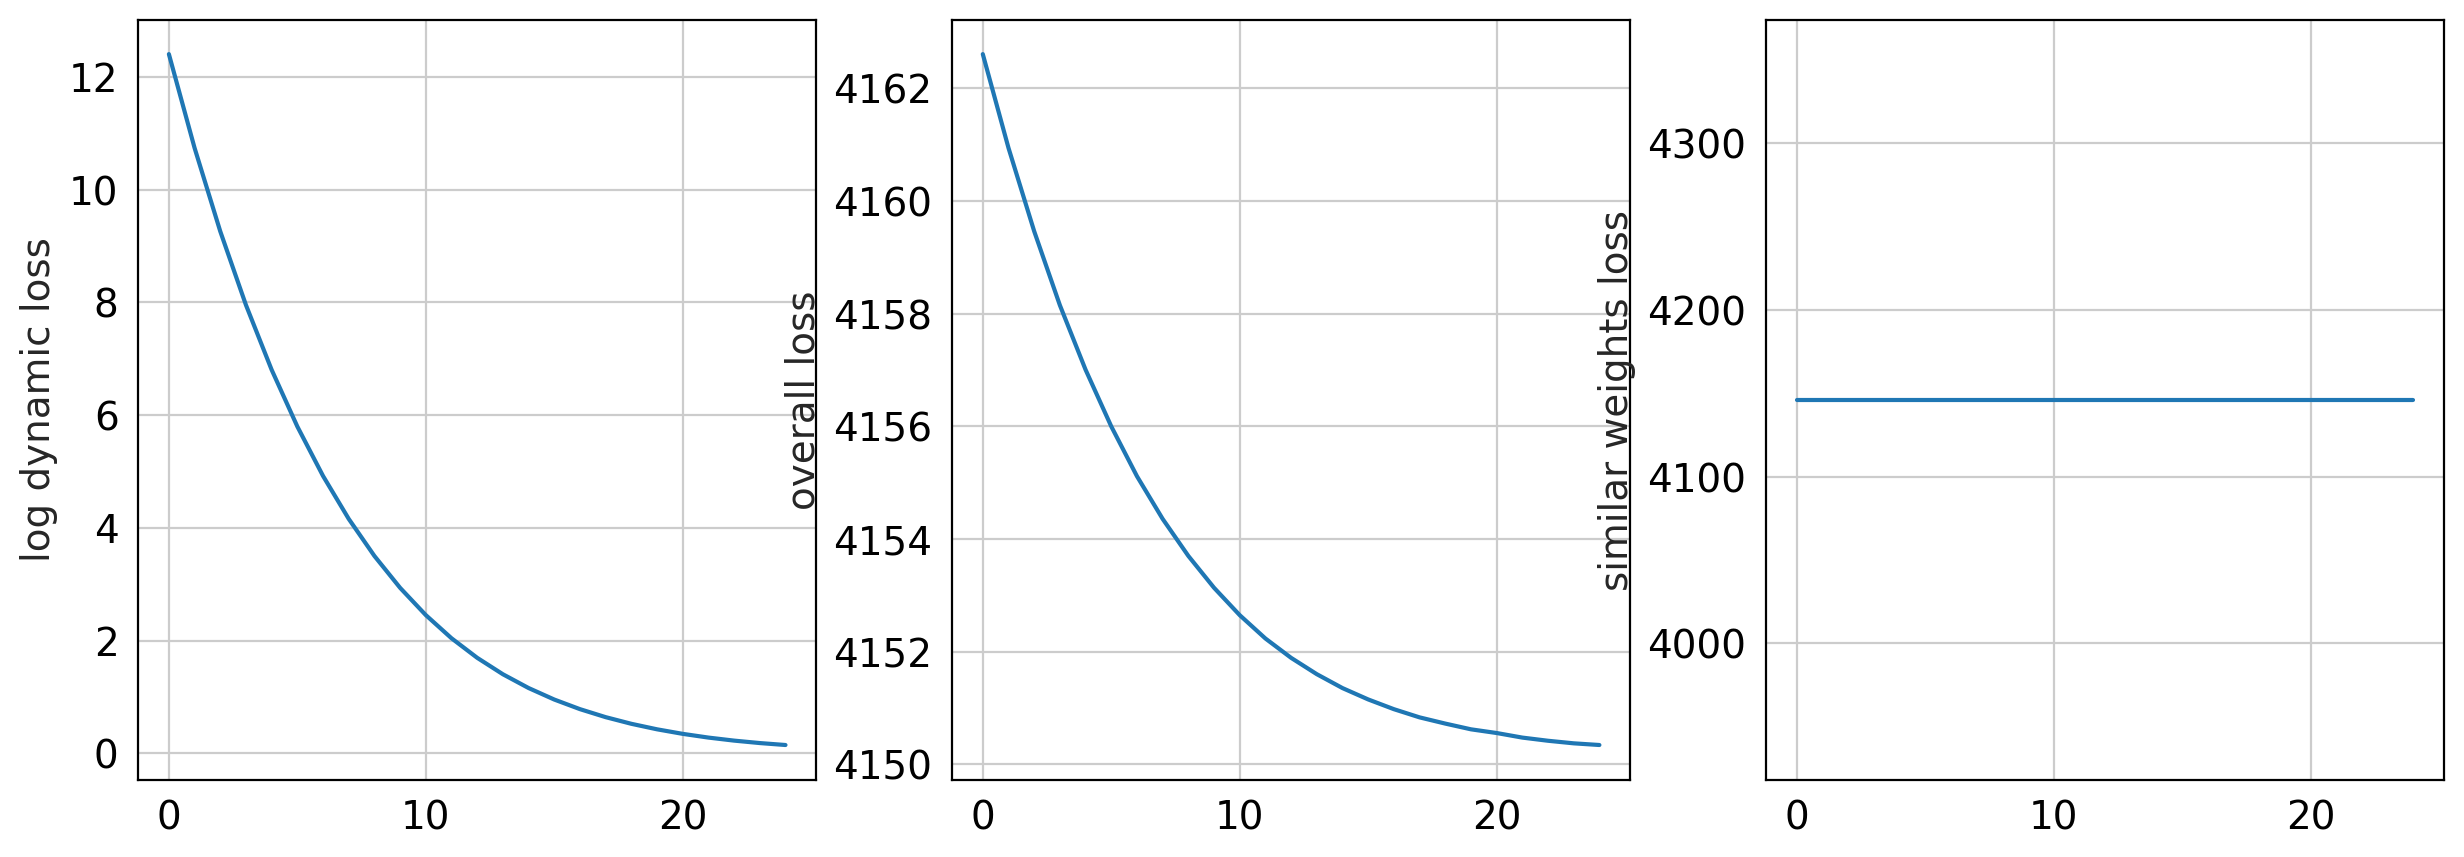

In [167]:
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')


In [168]:
print('here...')

here...


True
12
0 out of 288...
10 out of 288...


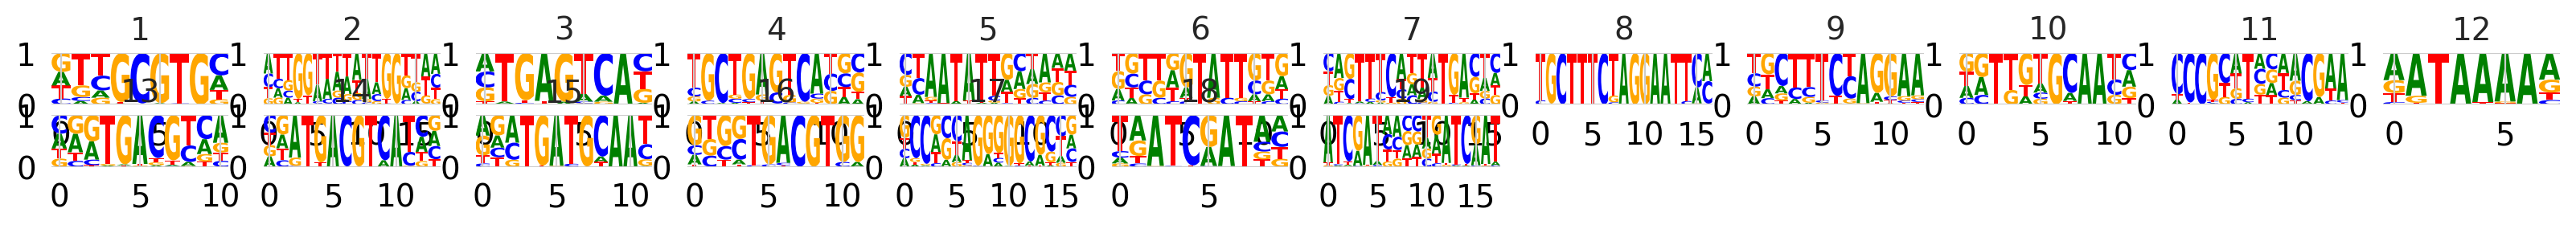

In [169]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=12, n_rows=10, show=True, stop_at=20)
plt.show()


In [170]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[  3,   6,   6,   8,   9,  14,  15,  16,  17,  25,  27,
                         29,  29,  29,  30,  31,  33,  38,  38,  41,  44,  48,
                         48,  49,  51,  52,  52,  53,  56,  58,  62,  72,  75,
                         75,  78,  78,  79,  81,  87,  89,  89,  91,  93,  94,
                         98, 100, 100, 101, 102, 102, 105, 105, 106, 107, 110,
                        112, 112, 114, 115, 117, 120, 121, 122, 129, 136, 138,
                        140, 141, 144, 146, 146, 149, 149, 152, 161, 161, 161,
                        163, 164, 168, 168, 170, 171, 174, 177, 180, 181, 184,
                        186, 187, 189, 192, 193, 194, 194, 196, 197, 199, 200,
                        201, 203, 205, 206, 210, 210, 212, 213, 219, 219, 219,
                        220, 221, 222, 226, 227, 232, 234, 234, 234, 235, 240,
                        242, 244, 245, 246, 247, 251, 252, 252, 252, 256, 256,
                        258, 259, 260, 261, 264, 266

<AxesSubplot: >

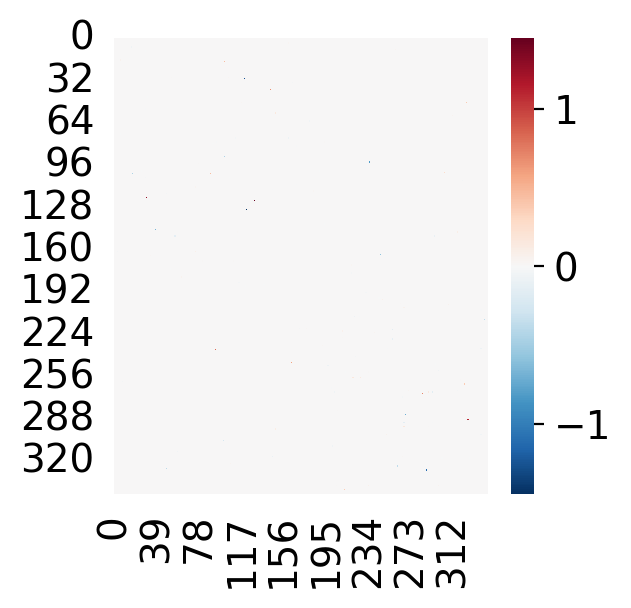

In [171]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

In [172]:
model.best_r2_by_new_filter

[]

In [173]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [174]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [175]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [176]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

Text(0.5, 12.355555555555531, 'dynamic score (normalized)')

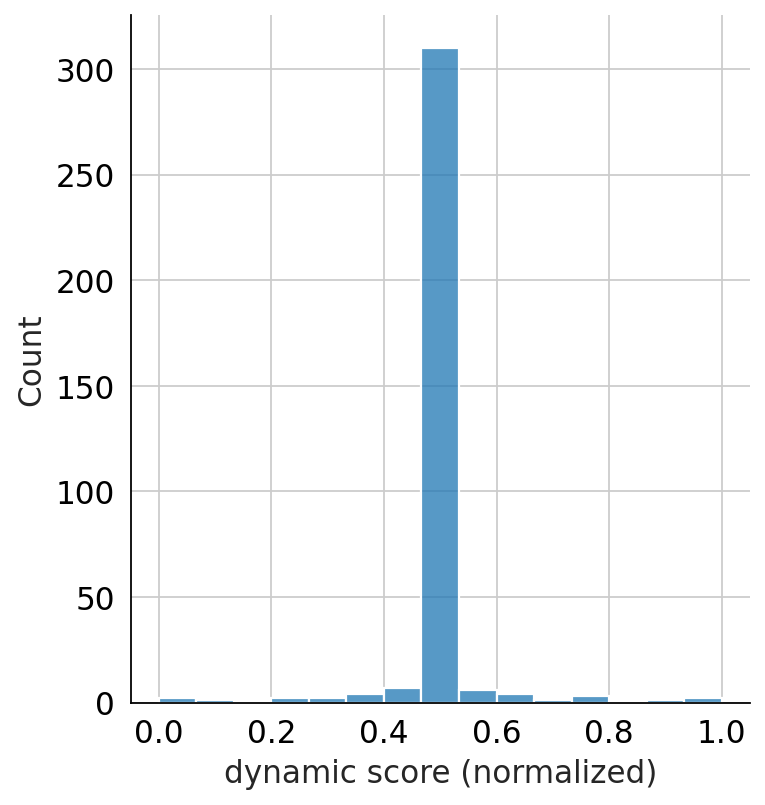

In [177]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score, bins=15)
plt.xlabel('dynamic score (normalized)')


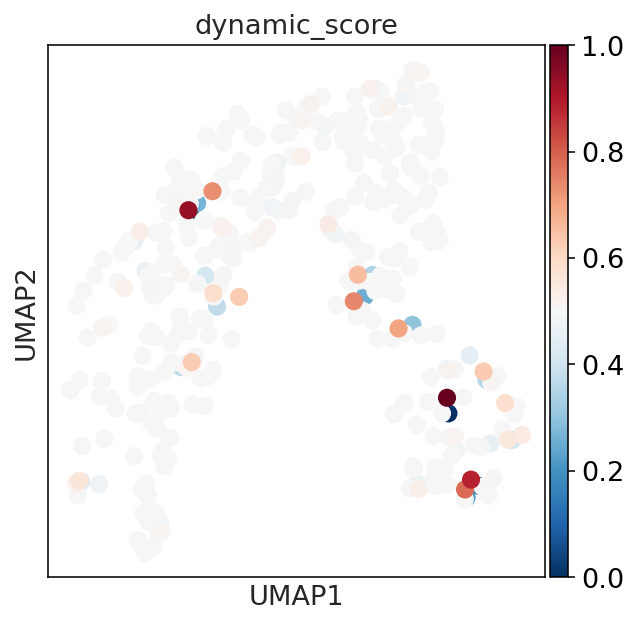

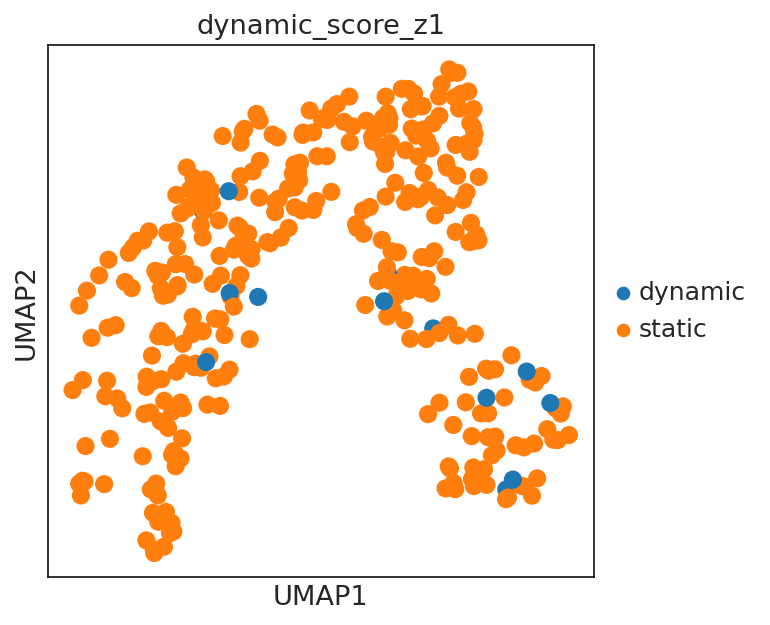

In [178]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 70
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [179]:
ad.obs['dynamic_score_z1']

AAACCAACATGAGTTT-1-0    static
AAACGCGCAGCAACCT-1-0    static
AAAGCACCAATAATGG-1-0    static
AACAAGCCAGCCGCTA-1-0    static
AACCTCACAAGGTCCT-1-0    static
                         ...  
TTGGCTACAATATAGG-1-1    static
TTGTCCATCCACAATA-1-1    static
TTGTGAGGTCATCAAG-1-1    static
TTTACGCGTGTTTGCT-1-1    static
TTTGACTTCCCGCCTA-1-1    static
Name: dynamic_score_z1, Length: 345, dtype: category
Categories (2, object): ['dynamic', 'static']

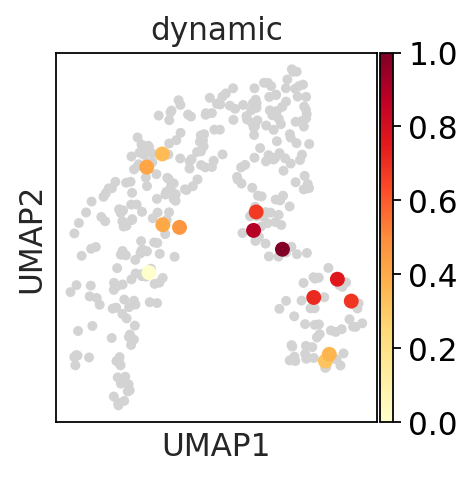

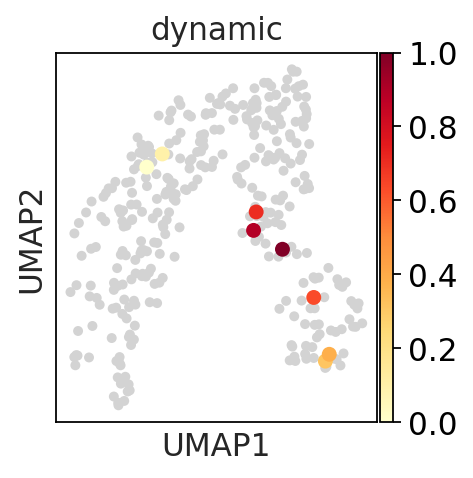

In [180]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [181]:
sc.set_figure_params()

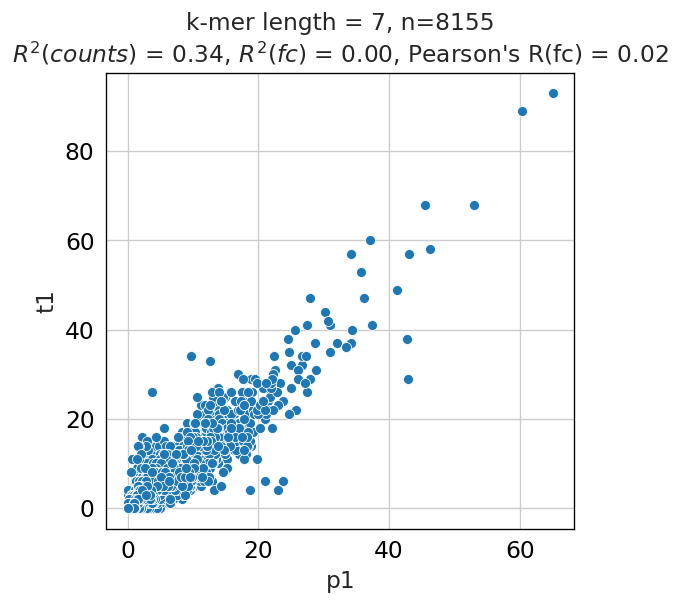

{'r2_counts': 0.34127125131917435,
 'r2_foldchange': -0.008520918626249374,
 'r2_enr': 0.019388719808617783,
 'r2_fc': 0.0003733693806353227,
 'pearson_foldchange': 0.01932276845163039}

In [182]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 60})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=7)


In [183]:
umap = ad.obsm['X_umap'].copy()
umap = np.sort(umap, 0)

x = umap[:,0]
y = umap[:,1]
X, Y = np.meshgrid(x, y)

n_points = x.shape[0]
# x-component to the right
u = np.ones((n_points, n_points))
# y-component zero
v = np.zeros((n_points, n_points))

In [184]:
D.shape

torch.Size([345, 345])

In [185]:
import scvelo as scv

In [186]:
ad.shape

(345, 688)

In [187]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

torch.Size([345, 288])

In [188]:
train.dataset.mononuc.shape

(688, 4, 330)

In [189]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
ad.layers['velocity'] = pred
ad.layers['counts'] = ad.X

here...
(512, 345)
14820.998
here...
(176, 345)
4868.0005


In [190]:
ad.layers['counts']

<345x688 sparse matrix of type '<class 'numpy.float32'>'
	with 14169 stored elements in Compressed Sparse Row format>

(array([30., 50., 32., 18.,  8., 14.,  2., 14.,  0., 14.]),
 array([0.03913021, 0.13521719, 0.23130417, 0.32739115, 0.42347813,
        0.51956511, 0.61565208, 0.71173906, 0.80782604, 0.90391302,
        1.        ]),
 <BarContainer object of 10 artists>)

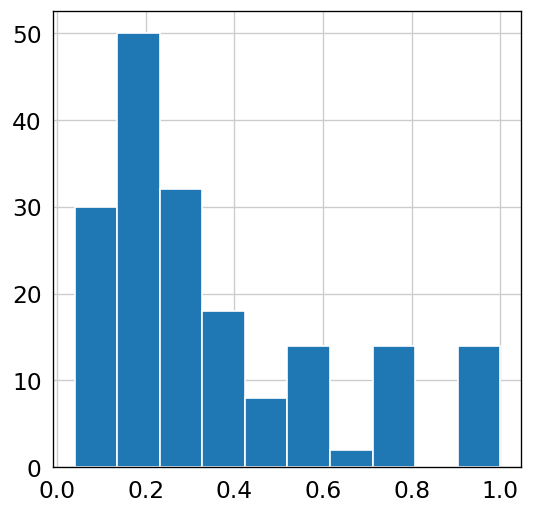

In [191]:
plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())

In [192]:
pred.shape

(345, 688)

In [193]:
ad.shape

(345, 688)

In [194]:
sc.pp.neighbors(ad)

In [195]:
# ad.layers['log_act'] = dyn_umap.X
# ad.layers['counts'] = ad.X
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')

computing velocity graph (using 1/16 cores)


  0%|          | 0/345 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


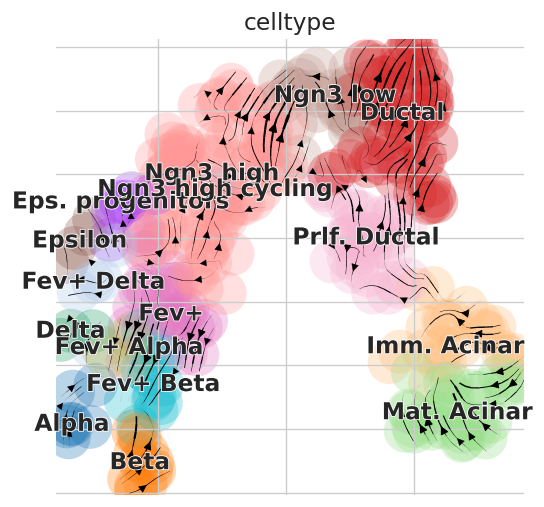

In [196]:
scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)


In [197]:
ad.shape

(345, 688)

In [198]:
act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
# log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
# log_act


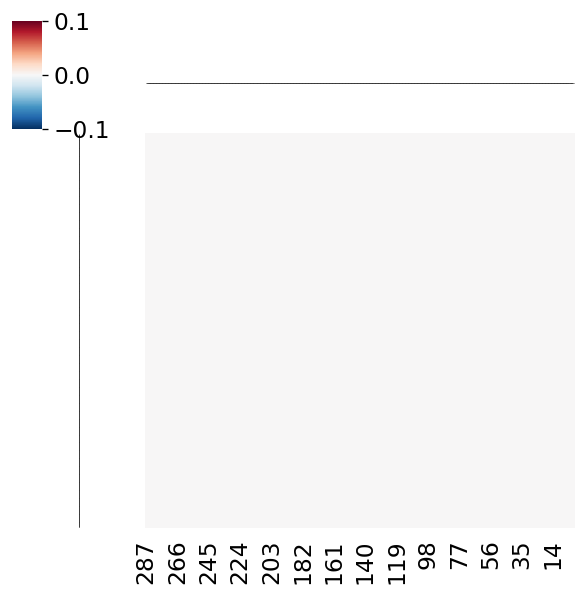

In [199]:
vmax = act.abs().max()
sns.clustermap(act.detach().cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

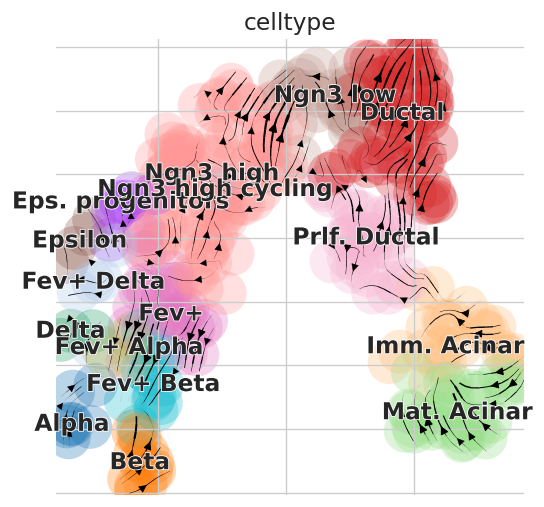

In [200]:

scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)


In [201]:
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()


In [202]:
rna_sel.var[rna_sel.var_names.str.startswith('Neu')]

,modality
Neu2,GEX
Neurod1,GEX
Neurl2,GEX
Neu3,GEX
Neurog3,GEX
Neurl4,GEX
Neurod2,GEX
Neurl1b,GEX
Neu1,GEX
Neurl1a,GEX


In [203]:
rna.var_names[rna.var_names == 'Neurog3']

Index(['Neurog3'], dtype='object')

In [204]:
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'

In [205]:
anno.columns

Index(['Cluster_ID', 'Name', 'DBD', 'Seed_motif', 'Total_width',
       'Consensus_left', 'Consensus_right', 'Cluster_size'],
      dtype='object')

In [206]:
# sns.clustermap(log_act.detach().numpy())

In [207]:
for i in range(2, log_act.shape[1]):
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [208]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act

In [209]:
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

In [210]:
names_neurog = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains('NEU')]['Cluster_ID'].values))]['Seed_motif'].values


In [211]:
names_clu = list(anno['Seed_motif'].values)

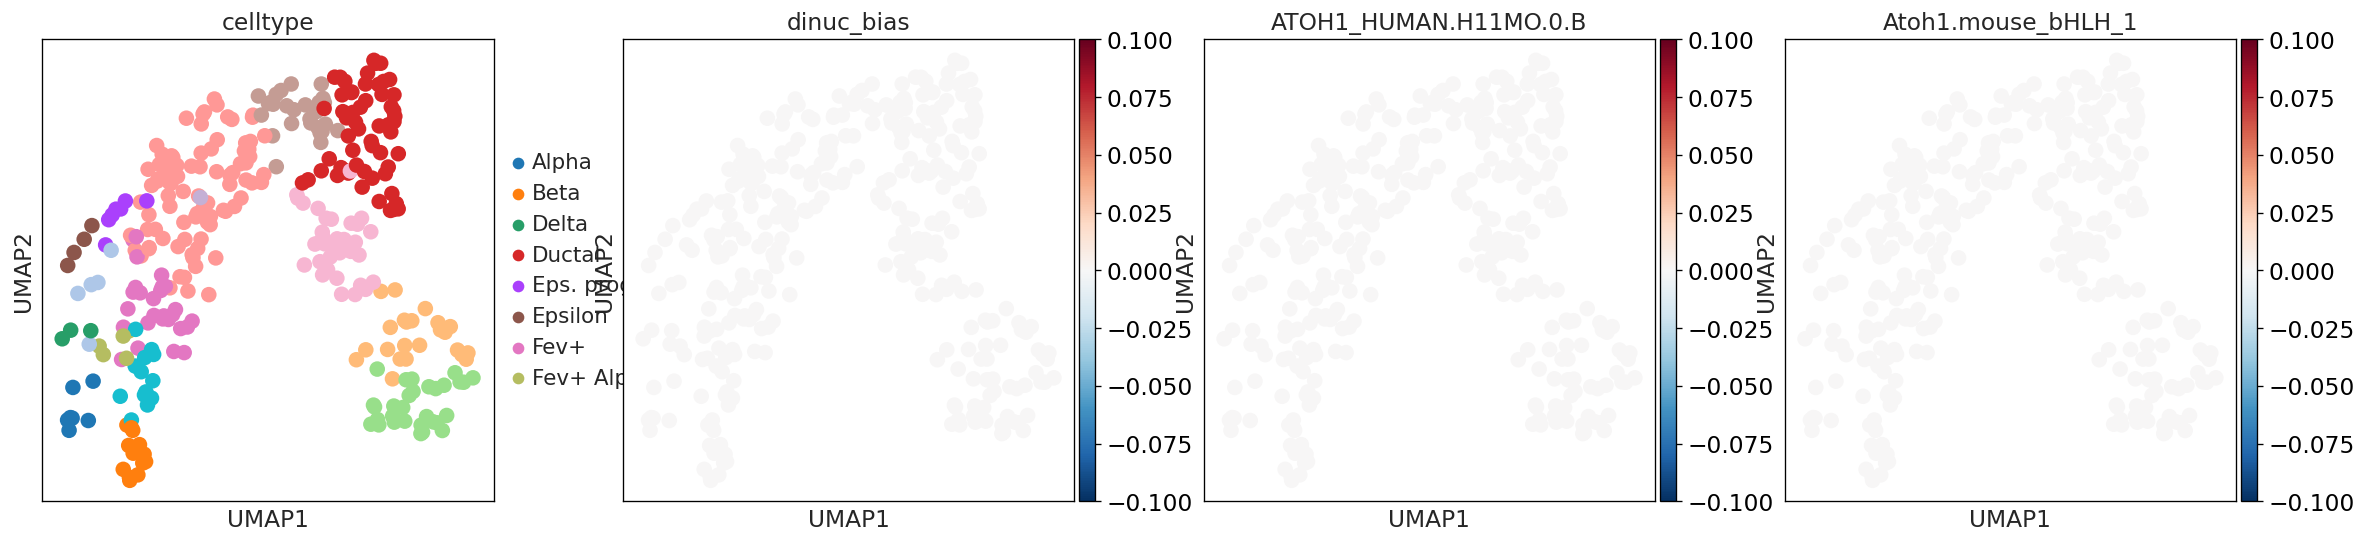

In [212]:

sc.pl.umap(ad, color=['celltype', 'dinuc_bias'] + list(names_neurog), cmap='RdBu_r', ncols=5)


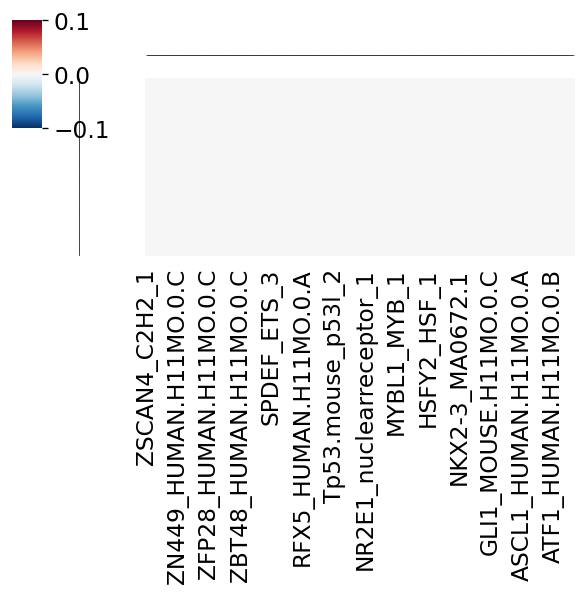

In [213]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

In [221]:
model

Multibind(
  (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
      (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
      (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
      (12): Conv2d(1, 1, kernel_size=(4, 15), strid

Multibind(
  (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
      (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
      (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
      (12): Conv2d(1, 1, kernel_size=(4, 15), strid

Multibind(
  (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
      (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
      (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
      (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
      (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
      (12): Conv2d(1, 1, kernel_size=(4, 15), strid

Text(0.5, 1.0, 'TF modules (by score)')

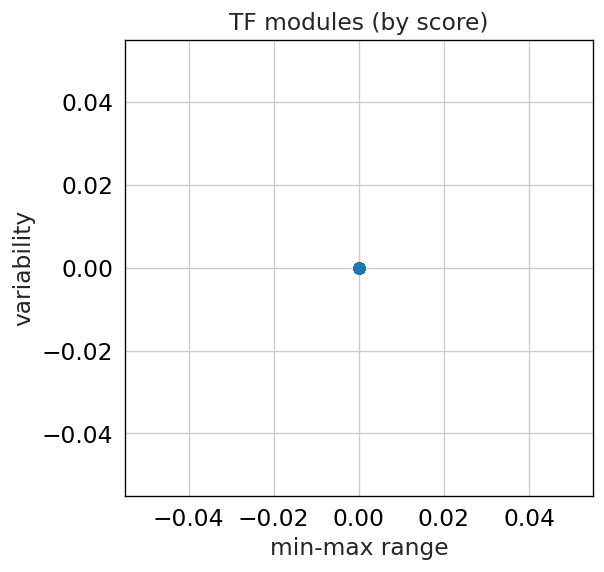

In [214]:
delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

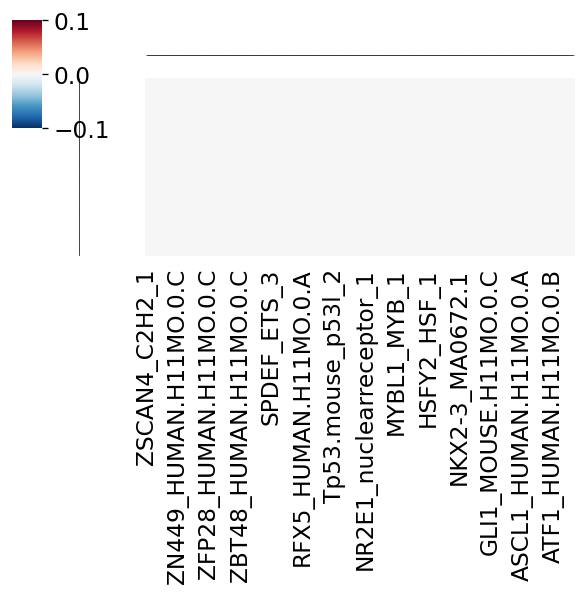

In [215]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

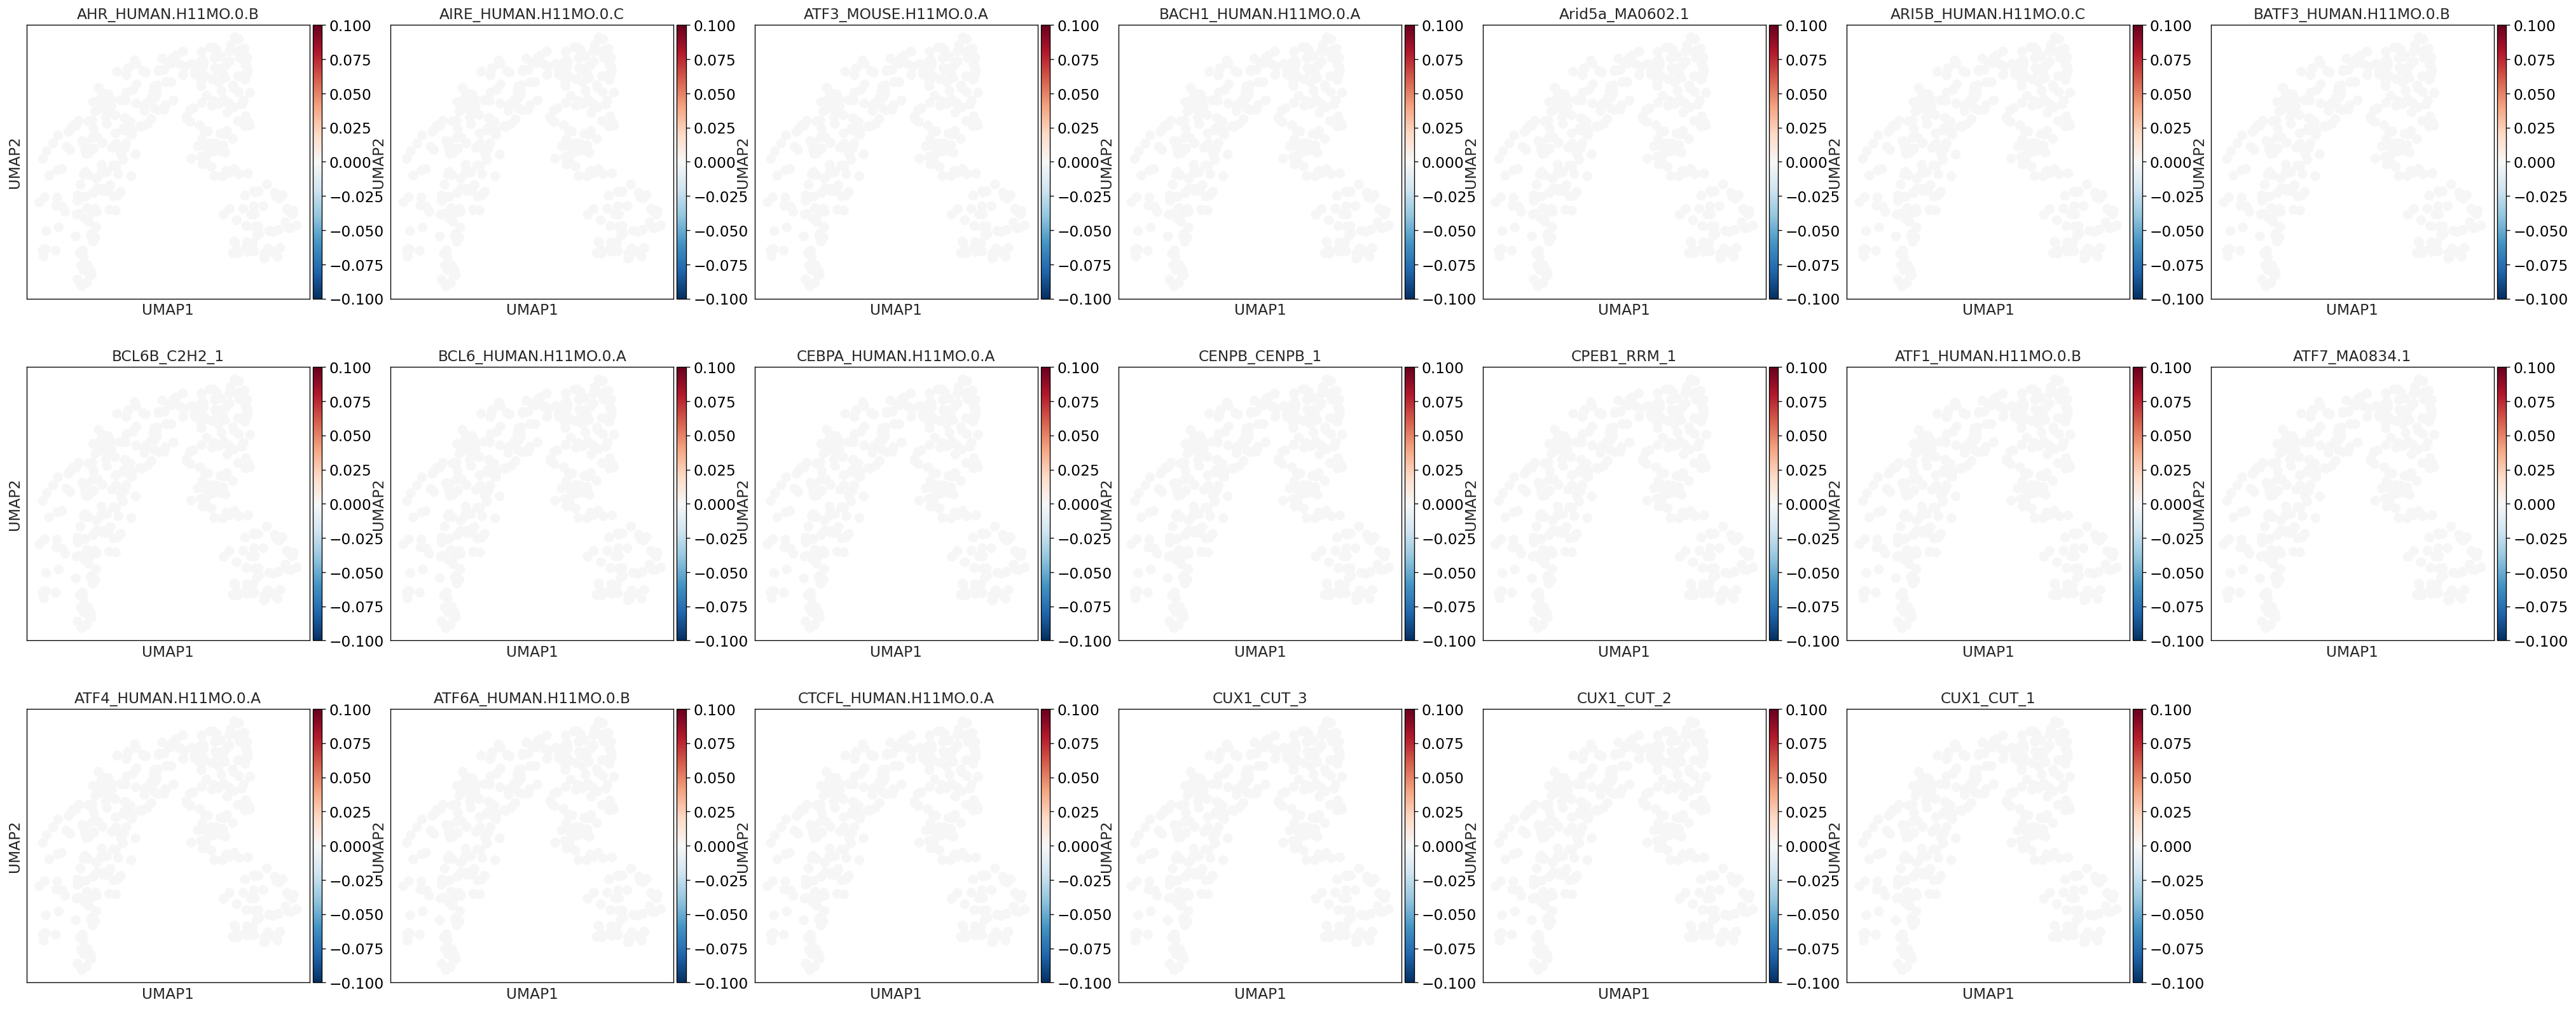

In [216]:
sc.pl.umap(ad, color=names_clu[:20], cmap='RdBu_r', ncols=7)


In [217]:
rna_sel.obs['score'] = log_act[:,63].detach().cpu().numpy()

InvalidIndexError: (slice(None, None, None), 63)

In [ ]:
sc.pl.umap(rna_sel, color=['celltype', 'score', 'dinuc_bias'], cmap='RdBu_r')
